# Importing all Packages Needed

In [2]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
import os
import random
%matplotlib inline

# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML



# Functions for Lane Detection

In [3]:

def grayscale(image):
    return cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

def hsv(image):
    return cv2.cvtColor(image, cv2.COLOR_RGB2HSV)


def gaussian_blur(image,kernel_size):
    return cv2.GaussianBlur(image,(kernel_size,kernel_size),0)    

def canny(image, low_threshold, high_threshold):
    return cv2.Canny(image, low_threshold, high_threshold)

def make_coordinates(image, line_parameters):
    slope, intercept = line_parameters
    y1 = image.shape[0]
    y2 = int(y1*(3/5)) #y=mx+b
    x1 = int((y1 - intercept)/slope)
    x2 = int((y2 - intercept)/slope)
    return np.array([x1, y1, x2, y2])

    

def average_slope_intercept(image, lines):
    left_fit = []
    right_fit = []
    for line in lines:
        x1, y1, x2, y2=line.reshape(4)
        parameters = np.polyfit((x1, x2),(y1, y2), 1)
        slope = parameters[0]
        intercept = parameters[1]
        if slope < 0:
            left_fit.append((slope,intercept))
        else:
            right_fit.append((slope,intercept))
    left_fit_average = np.average(left_fit, axis = 0)
    right_fit_average = np.average(right_fit, axis = 0)
    left_line = make_coordinates(image,left_fit_average)
    right_line =make_coordinates(image,right_fit_average)
    return np.array([left_line, right_line])

def region_of_interest(image,roi):
    blank = np.zeros_like(image)
    mask = cv2.fillPoly(blank,roi,255)
    masked_image = cv2.bitwise_and(image,mask)
    return masked_image

def hough_transform(image, rho, theta,threshold,min_line_len,max_line_gap):
    return cv2.HoughLinesP(image,rho, theta,threshold,np.array([]), minLineLength=min_line_len,maxLineGap=max_line_gap)

def display_lines(image, lines):
    line_image = np.zeros_like(image)
    if lines is not None:
        for line in lines:
            x1, y1 , x2, y2 = line.reshape(4)
            cv2.line(line_image,(x1,y1),(x2,y2),(255, 0, 0), 20)
    return line_image   


# Test on Images

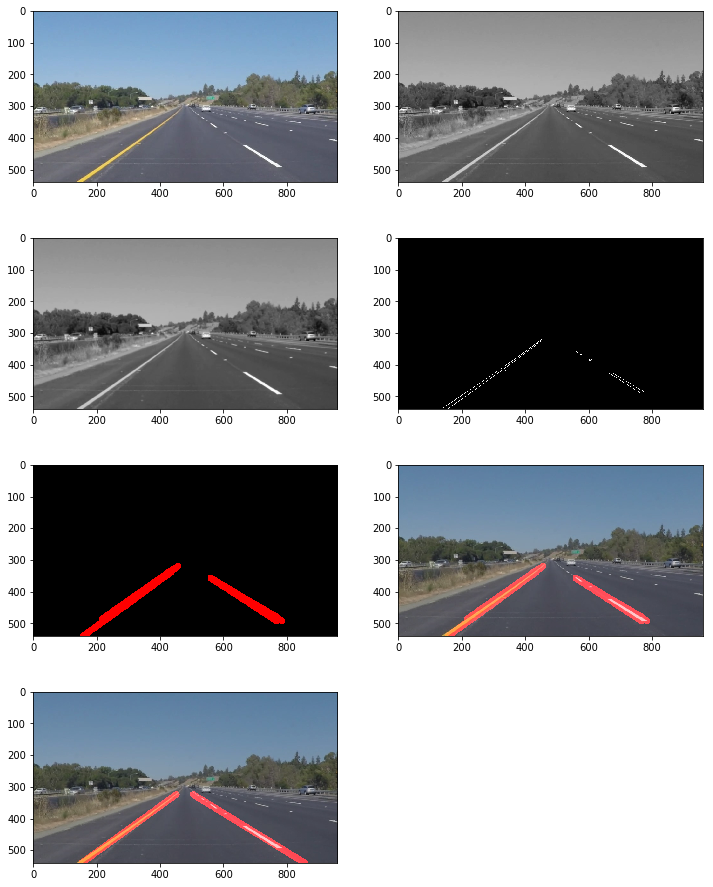

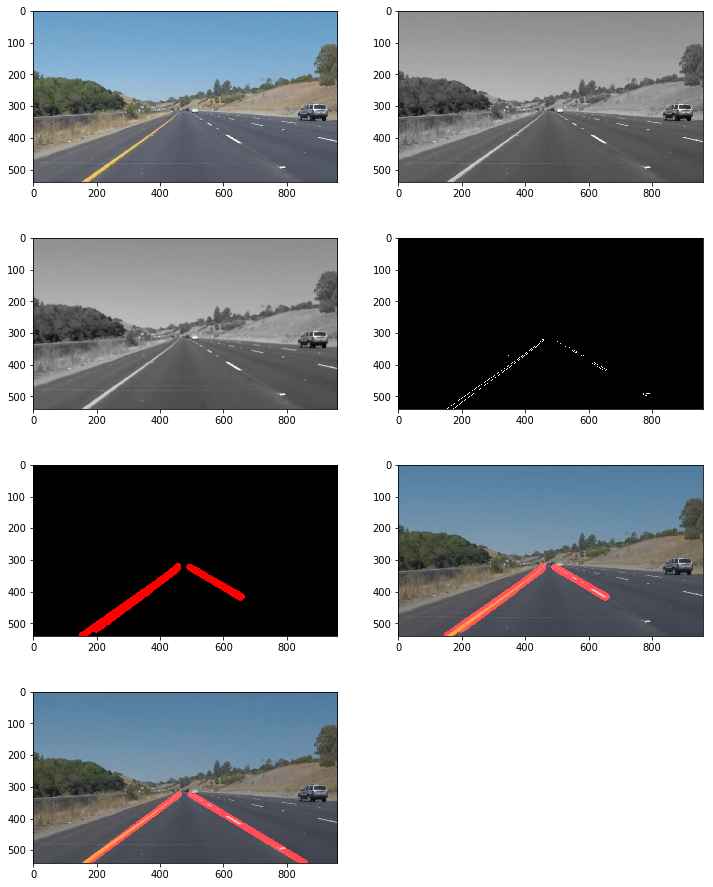

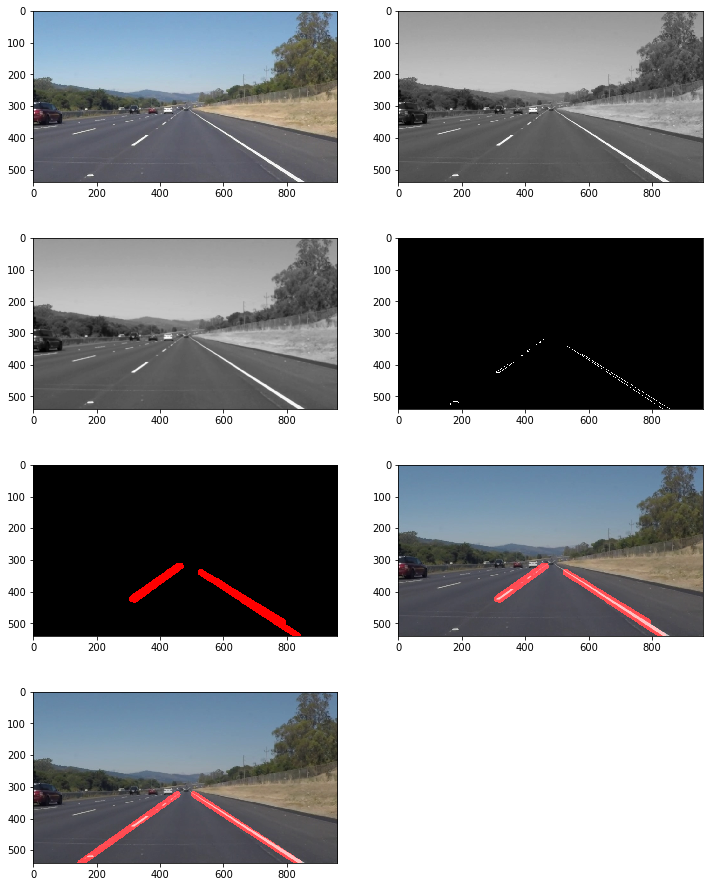

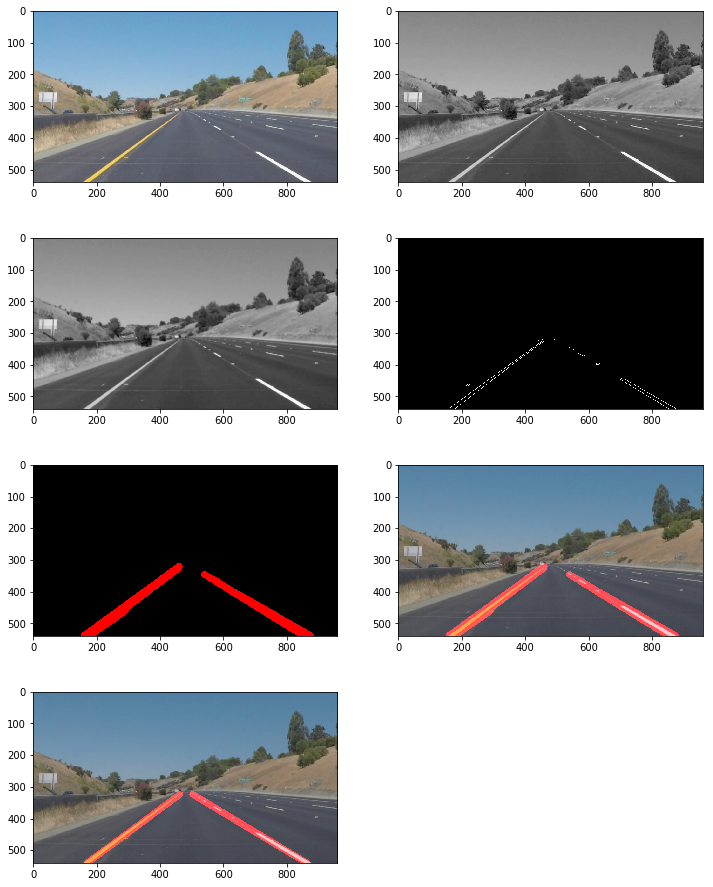

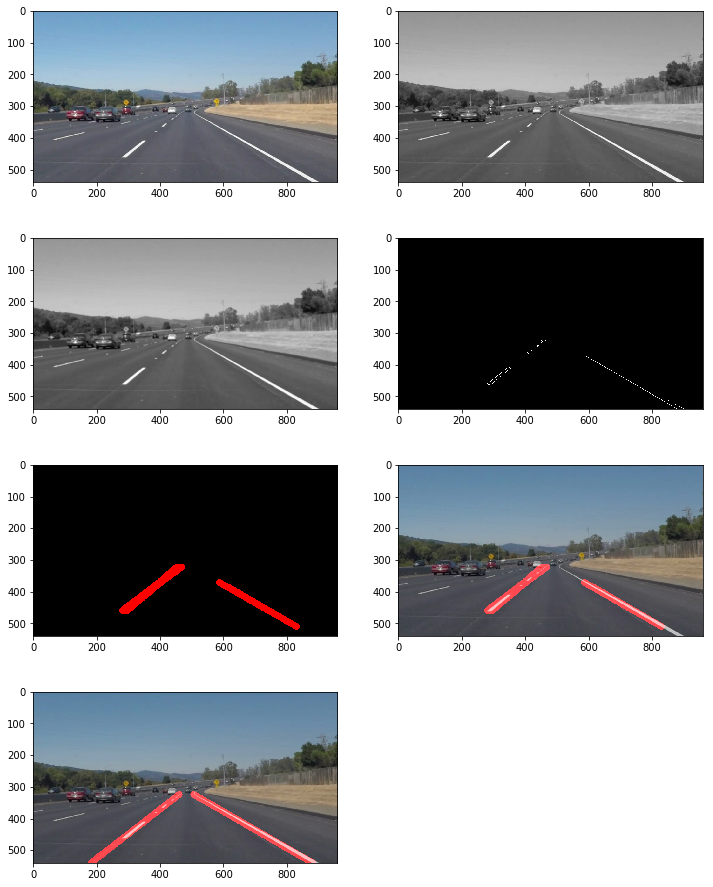

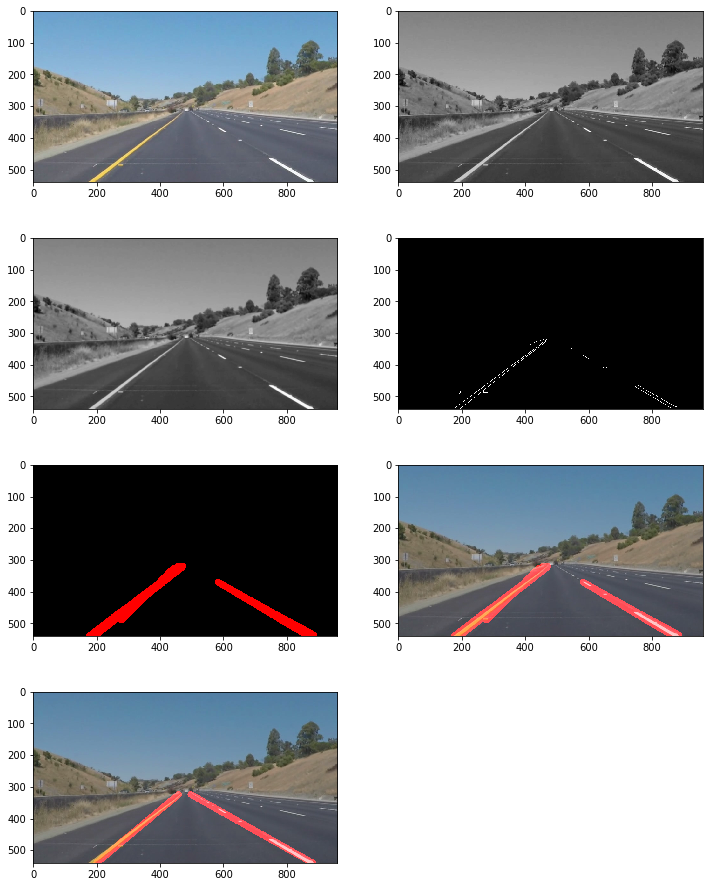

In [4]:
path = "test_images/"
test_imgs = os.listdir(path)

for img in test_imgs:
    #read image
    lane_image = mpimg.imread("test_images/" + img)
    image = np.copy(lane_image)

    fig=plt.figure()
    fig.set_figheight(16)
    fig.set_figwidth(12)
    
    #show image
    plot_1 = fig.add_subplot(4,2,1)
    plot_1.imshow(image)
    
    #convert in grayscale
    image_gray = grayscale(image)
    plot_2 =fig.add_subplot(4,2,2)
    plot_2.imshow(image_gray, cmap = 'gray')
    
    #apply guassian blur
    image_blur =gaussian_blur(image_gray,5)
    plot_3 = fig.add_subplot(4,2,3)
    plot_3.imshow(image_blur, cmap = 'gray')
    
    #apply canny edge detection
    image_canny=canny(image_blur,50,150)
    plot_4 = fig.add_subplot(4,2,4)
    plot_4.imshow(image_canny, cmap = 'gray')
    
    #apply region of interest
    roi = np.array([[(0,540),(450,320),(490,320),(900,540)]],dtype=np.int32)
    cropped_image = region_of_interest(image_canny,roi)
    plot_4 = fig.add_subplot(4,2,4)
    plot_4.imshow(cropped_image, cmap = 'gray')
    
    
    #apply hough transform
    lines = hough_transform(cropped_image, 3, np.pi/180, 50, 100, 100)
    
    #display lines on black screen
    line_image =display_lines(image,lines)
    plot_5 = fig.add_subplot(4,2,5)
    plot_5.imshow(line_image)
    
    #display lines on original image
    combo_image = cv2.addWeighted(image, 0.8, line_image, 1, 1)
    plot_6 = fig.add_subplot(4,2,6)
    plot_6.imshow(combo_image)
    
   #optimizing
    averaged_lines = average_slope_intercept(image, lines)
    line_image = display_lines(image, averaged_lines)
    combo_image = cv2.addWeighted(image, 0.8, line_image, 1, 1)
    plot_7 = fig.add_subplot(4,2,7)
    plot_7.imshow(combo_image)
    
    
    


# Building a Pipeline


In [5]:
def lane_finding_pipeline(image):
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    blur= cv2.GaussianBlur(gray,(5,5),0)
    edges = cv2.Canny(blur, 50, 200)
    
    #roi
    rows, cols = image.shape[:2]
    mask = np.zeros_like(img)
    
    left_bottom = [cols * 0.1, rows]
    right_bottom = [cols * 0.95, rows]
    left_top = [cols * 0.4, rows * 0.6]
    right_top = [cols * 0.6, rows * 0.6]
    
    roi = np.array([[left_bottom, left_top, right_top, right_bottom]], dtype=np.int32)
    #roi = np.array([[(40,540),(400,350),(560,320),(900,540)]],dtype=np.int32)
    cropped_image = region_of_interest(image_canny,roi)
    lines = hough_transform(cropped_image, 3, np.pi/180, 50, 100, 100)
    averaged_lines = average_slope_intercept(image, lines)
    line_image = display_lines(image, averaged_lines)
    result = cv2.addWeighted(image, 0.8, line_image, 1, 1)
    return result
    

    

# Video test

In [6]:
white_output = 'test_videos_output/solidWhiteRight.mp4'
clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4")
white_clip = clip1.fl_image(lane_finding_pipeline) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

[MoviePy] >>>> Building video test_videos_output/solidWhiteRight.mp4
[MoviePy] Writing video test_videos_output/solidWhiteRight.mp4


100%|█████████▉| 221/222 [00:13<00:00, 16.88it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/solidWhiteRight.mp4 

CPU times: user 3.13 s, sys: 164 ms, total: 3.29 s
Wall time: 14.7 s


In [7]:
yellow_output = 'test_videos_output/yellow.mp4'
clips = VideoFileClip("test_videos/solidYellowLeft.mp4")
line_clips = clips.fl_image(lane_finding_pipeline) 
line_clips.write_videofile(yellow_output, audio=False)

HTML("""<video width="480" height="270" controls><source src="{0}"></video>""".format(yellow_output))

[MoviePy] >>>> Building video test_videos_output/yellow.mp4
[MoviePy] Writing video test_videos_output/yellow.mp4


100%|█████████▉| 681/682 [00:44<00:00, 15.45it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/yellow.mp4 



In [16]:
def lane_pipeline(image):
    image_gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    image_hsv = hsv(image)
    lower_yel = np.array([20,100,100])
    upper_yel = np.array([30,255,255])
    lower_wht = np.array([0,0,235])
    upper_wht = np.array([255,255,255])
    
    
    yellow_mask = cv2.inRange(image_hsv, lower_yel, upper_yel)
    white_mask = cv2.inRange(image_hsv, lower_wht, upper_wht)
    
    full_mask = cv2.bitwise_or(yellow_mask, white_mask)
    subdued_gray = (image_gray / 2).astype('uint8')
    boosted_lanes = cv2.bitwise_or(subdued_gray, full_mask)

    image_blur = gaussian_blur(boosted_lanes, 5)
    image_canny = canny(image_blur, 60, 150)
    
    #roi
    x = image_canny.shape[1]
    y = image_canny.shape[0]
    roi = np.array([[(x*0.,y),(x*.475, y*.575), (x*.525, y*.575), (x,y)]], dtype=np.int32)
  
  
    #roi = np.array([[(40,540),(400,350),(560,320),(900,540)]],dtype=np.int32)
    cropped_image = region_of_interest(image_canny,roi)
    lines = hough_transform(cropped_image, 3, np.pi/180, 50, 100, 100)
    averaged_lines = average_slope_intercept(image, lines)
    line_image = display_lines(image, averaged_lines)
    result = cv2.addWeighted(image, 0.8, line_image, 1, 1)
    return result
    

challenge_output = 'test_videos_output/challenge.mp4'
clip3 = VideoFileClip('test_videos/challenge.mp4')
challenge_clip = clip3.fl_image(lane_pipeline)
# %time challenge_clip.write_videofile(challenge_output, audio=False)
challenge_clip.write_videofile(challenge_output, audio=False)



1280
720
[[[   0  720]
  [ 608  413]
  [ 672  413]
  [1280  720]]]
[MoviePy] >>>> Building video test_videos_output/challenge.mp4
[MoviePy] Writing video test_videos_output/challenge.mp4


  1%|          | 2/251 [00:00<00:17, 14.19it/s]

1280
720
[[[   0  720]
  [ 608  413]
  [ 672  413]
  [1280  720]]]
1280
720
[[[   0  720]
  [ 608  413]
  [ 672  413]
  [1280  720]]]
1280
720
[[[   0  720]
  [ 608  413]
  [ 672  413]
  [1280  720]]]


  2%|▏         | 4/251 [00:00<00:17, 14.22it/s]

1280
720
[[[   0  720]
  [ 608  413]
  [ 672  413]
  [1280  720]]]
1280
720
[[[   0  720]
  [ 608  413]
  [ 672  413]
  [1280  720]]]
1280
720
[[[   0  720]
  [ 608  413]
  [ 672  413]
  [1280  720]]]


  2%|▏         | 6/251 [00:00<00:16, 14.49it/s]

1280
720
[[[   0  720]
  [ 608  413]
  [ 672  413]
  [1280  720]]]


  3%|▎         | 8/251 [00:00<00:16, 14.68it/s]

1280
720
[[[   0  720]
  [ 608  413]
  [ 672  413]
  [1280  720]]]
1280
720
[[[   0  720]
  [ 608  413]
  [ 672  413]
  [1280  720]]]
1280
720
[[[   0  720]
  [ 608  413]
  [ 672  413]
  [1280  720]]]


  4%|▍         | 10/251 [00:00<00:16, 14.82it/s]

1280
720
[[[   0  720]
  [ 608  413]
  [ 672  413]
  [1280  720]]]


  5%|▍         | 12/251 [00:00<00:16, 14.92it/s]

1280
720
[[[   0  720]
  [ 608  413]
  [ 672  413]
  [1280  720]]]
1280
720
[[[   0  720]
  [ 608  413]
  [ 672  413]
  [1280  720]]]
1280
720
[[[   0  720]
  [ 608  413]
  [ 672  413]
  [1280  720]]]


  6%|▌         | 14/251 [00:00<00:15, 15.01it/s]

1280
720
[[[   0  720]
  [ 608  413]
  [ 672  413]
  [1280  720]]]


  6%|▋         | 16/251 [00:01<00:15, 15.17it/s]

1280
720
[[[   0  720]
  [ 608  413]
  [ 672  413]
  [1280  720]]]
1280
720
[[[   0  720]
  [ 608  413]
  [ 672  413]
  [1280  720]]]
1280
720
[[[   0  720]
  [ 608  413]
  [ 672  413]
  [1280  720]]]


  7%|▋         | 18/251 [00:01<00:15, 15.30it/s]

1280
720
[[[   0  720]
  [ 608  413]
  [ 672  413]
  [1280  720]]]


  8%|▊         | 20/251 [00:01<00:15, 15.40it/s]

1280
720
[[[   0  720]
  [ 608  413]
  [ 672  413]
  [1280  720]]]
1280
720
[[[   0  720]
  [ 608  413]
  [ 672  413]
  [1280  720]]]
1280
720
[[[   0  720]
  [ 608  413]
  [ 672  413]
  [1280  720]]]


  9%|▉         | 22/251 [00:01<00:14, 15.32it/s]

1280
720
[[[   0  720]
  [ 608  413]
  [ 672  413]
  [1280  720]]]


 10%|▉         | 24/251 [00:01<00:14, 15.27it/s]

1280
720
[[[   0  720]
  [ 608  413]
  [ 672  413]
  [1280  720]]]
1280
720
[[[   0  720]
  [ 608  413]
  [ 672  413]
  [1280  720]]]
1280
720
[[[   0  720]
  [ 608  413]
  [ 672  413]
  [1280  720]]]


 10%|█         | 26/251 [00:01<00:14, 15.26it/s]

1280
720
[[[   0  720]
  [ 608  413]
  [ 672  413]
  [1280  720]]]


 11%|█         | 28/251 [00:01<00:14, 15.36it/s]

1280
720
[[[   0  720]
  [ 608  413]
  [ 672  413]
  [1280  720]]]
1280
720
[[[   0  720]
  [ 608  413]
  [ 672  413]
  [1280  720]]]
1280
720
[[[   0  720]
  [ 608  413]
  [ 672  413]
  [1280  720]]]


 12%|█▏        | 30/251 [00:01<00:14, 15.14it/s]

1280
720
[[[   0  720]
  [ 608  413]
  [ 672  413]
  [1280  720]]]

 13%|█▎        | 32/251 [00:02<00:14, 15.28it/s]


1280
720
[[[   0  720]
  [ 608  413]
  [ 672  413]
  [1280  720]]]
1280
720
[[[   0  720]
  [ 608  413]
  [ 672  413]
  [1280  720]]]
1280
720
[[[   0  720]
  [ 608  413]
  [ 672  413]
  [1280  720]]]


 14%|█▍        | 36/251 [00:02<00:14, 15.26it/s]

1280
720
[[[   0  720]
  [ 608  413]
  [ 672  413]
  [1280  720]]]
1280
720
[[[   0  720]
  [ 608  413]
  [ 672  413]
  [1280  720]]]
1280
720
[[[   0  720]
  [ 608  413]
  [ 672  413]
  [1280  720]]]
1280
720
[[[   0  720]
  [ 608  413]
  [ 672  413]
  [1280  720]]]


 16%|█▌        | 40/251 [00:02<00:13, 15.34it/s]

1280
720
[[[   0  720]
  [ 608  413]
  [ 672  413]
  [1280  720]]]
1280
720
[[[   0  720]
  [ 608  413]
  [ 672  413]
  [1280  720]]]
1280
720
[[[   0  720]
  [ 608  413]
  [ 672  413]
  [1280  720]]]
1280
720
[[[   0  720]
  [ 608  413]
  [ 672  413]
  [1280  720]]]


 17%|█▋        | 42/251 [00:02<00:13, 15.29it/s]

1280
720
[[[   0  720]
  [ 608  413]
  [ 672  413]
  [1280  720]]]


 18%|█▊        | 44/251 [00:03<00:21,  9.48it/s]

1280
720
[[[   0  720]
  [ 608  413]
  [ 672  413]
  [1280  720]]]
1280
720
[[[   0  720]
  [ 608  413]
  [ 672  413]
  [1280  720]]]


 18%|█▊        | 46/251 [00:03<00:24,  8.27it/s]

1280
720
[[[   0  720]
  [ 608  413]
  [ 672  413]
  [1280  720]]]
1280
720
[[[   0  720]
  [ 608  413]
  [ 672  413]
  [1280  720]]]


 19%|█▉        | 48/251 [00:03<00:26,  7.79it/s]

1280
720
[[[   0  720]
  [ 608  413]
  [ 672  413]
  [1280  720]]]
1280
720
[[[   0  720]
  [ 608  413]
  [ 672  413]
  [1280  720]]]


 20%|█▉        | 50/251 [00:04<00:27,  7.32it/s]

1280
720
[[[   0  720]
  [ 608  413]
  [ 672  413]
  [1280  720]]]
1280
720
[[[   0  720]
  [ 608  413]
  [ 672  413]
  [1280  720]]]


 21%|██        | 52/251 [00:04<00:28,  7.07it/s]

1280
720
[[[   0  720]
  [ 608  413]
  [ 672  413]
  [1280  720]]]
1280
720
[[[   0  720]
  [ 608  413]
  [ 672  413]
  [1280  720]]]


 22%|██▏       | 54/251 [00:04<00:28,  6.92it/s]

1280
720
[[[   0  720]
  [ 608  413]
  [ 672  413]
  [1280  720]]]
1280
720
[[[   0  720]
  [ 608  413]
  [ 672  413]
  [1280  720]]]


 22%|██▏       | 56/251 [00:04<00:28,  6.75it/s]

1280
720
[[[   0  720]
  [ 608  413]
  [ 672  413]
  [1280  720]]]
1280
720
[[[   0  720]
  [ 608  413]
  [ 672  413]
  [1280  720]]]


 23%|██▎       | 58/251 [00:05<00:29,  6.55it/s]

1280
720
[[[   0  720]
  [ 608  413]
  [ 672  413]
  [1280  720]]]
1280
720
[[[   0  720]
  [ 608  413]
  [ 672  413]
  [1280  720]]]


 24%|██▍       | 60/251 [00:05<00:29,  6.41it/s]

1280
720
[[[   0  720]
  [ 608  413]
  [ 672  413]
  [1280  720]]]
1280
720
[[[   0  720]
  [ 608  413]
  [ 672  413]
  [1280  720]]]


 25%|██▍       | 62/251 [00:05<00:28,  6.63it/s]

1280
720
[[[   0  720]
  [ 608  413]
  [ 672  413]
  [1280  720]]]
1280
720
[[[   0  720]
  [ 608  413]
  [ 672  413]
  [1280  720]]]


 25%|██▌       | 64/251 [00:06<00:28,  6.68it/s]

1280
720
[[[   0  720]
  [ 608  413]
  [ 672  413]
  [1280  720]]]
1280
720
[[[   0  720]
  [ 608  413]
  [ 672  413]
  [1280  720]]]


 26%|██▋       | 66/251 [00:06<00:27,  6.66it/s]

1280
720
[[[   0  720]
  [ 608  413]
  [ 672  413]
  [1280  720]]]
1280
720
[[[   0  720]
  [ 608  413]
  [ 672  413]
  [1280  720]]]


 27%|██▋       | 68/251 [00:06<00:27,  6.55it/s]

1280
720
[[[   0  720]
  [ 608  413]
  [ 672  413]
  [1280  720]]]
1280
720
[[[   0  720]
  [ 608  413]
  [ 672  413]
  [1280  720]]]


 28%|██▊       | 70/251 [00:07<00:27,  6.50it/s]

1280
720
[[[   0  720]
  [ 608  413]
  [ 672  413]
  [1280  720]]]
1280
720
[[[   0  720]
  [ 608  413]
  [ 672  413]
  [1280  720]]]


 29%|██▊       | 72/251 [00:07<00:27,  6.49it/s]

1280
720
[[[   0  720]
  [ 608  413]
  [ 672  413]
  [1280  720]]]
1280
720
[[[   0  720]
  [ 608  413]
  [ 672  413]
  [1280  720]]]


 29%|██▉       | 74/251 [00:07<00:27,  6.48it/s]

1280
720
[[[   0  720]
  [ 608  413]
  [ 672  413]
  [1280  720]]]
1280
720
[[[   0  720]
  [ 608  413]
  [ 672  413]
  [1280  720]]]


 30%|███       | 76/251 [00:08<00:26,  6.54it/s]

1280
720
[[[   0  720]
  [ 608  413]
  [ 672  413]
  [1280  720]]]
1280
720
[[[   0  720]
  [ 608  413]
  [ 672  413]
  [1280  720]]]


 31%|███       | 78/251 [00:08<00:26,  6.44it/s]

1280
720
[[[   0  720]
  [ 608  413]
  [ 672  413]
  [1280  720]]]
1280
720
[[[   0  720]
  [ 608  413]
  [ 672  413]
  [1280  720]]]


 32%|███▏      | 80/251 [00:08<00:26,  6.49it/s]

1280
720
[[[   0  720]
  [ 608  413]
  [ 672  413]
  [1280  720]]]
1280
720
[[[   0  720]
  [ 608  413]
  [ 672  413]
  [1280  720]]]


 33%|███▎      | 82/251 [00:08<00:26,  6.47it/s]

1280
720
[[[   0  720]
  [ 608  413]
  [ 672  413]
  [1280  720]]]
1280
720
[[[   0  720]
  [ 608  413]
  [ 672  413]
  [1280  720]]]


 33%|███▎      | 84/251 [00:09<00:26,  6.39it/s]

1280
720
[[[   0  720]
  [ 608  413]
  [ 672  413]
  [1280  720]]]
1280
720
[[[   0  720]
  [ 608  413]
  [ 672  413]
  [1280  720]]]


 34%|███▍      | 86/251 [00:09<00:25,  6.41it/s]

1280
720
[[[   0  720]
  [ 608  413]
  [ 672  413]
  [1280  720]]]
1280
720
[[[   0  720]
  [ 608  413]
  [ 672  413]
  [1280  720]]]


 35%|███▌      | 88/251 [00:09<00:25,  6.49it/s]

1280
720
[[[   0  720]
  [ 608  413]
  [ 672  413]
  [1280  720]]]
1280
720
[[[   0  720]
  [ 608  413]
  [ 672  413]
  [1280  720]]]


 36%|███▌      | 90/251 [00:10<00:25,  6.35it/s]

1280
720
[[[   0  720]
  [ 608  413]
  [ 672  413]
  [1280  720]]]
1280
720
[[[   0  720]
  [ 608  413]
  [ 672  413]
  [1280  720]]]


 37%|███▋      | 92/251 [00:10<00:24,  6.37it/s]

1280
720
[[[   0  720]
  [ 608  413]
  [ 672  413]
  [1280  720]]]
1280
720
[[[   0  720]
  [ 608  413]
  [ 672  413]
  [1280  720]]]


 37%|███▋      | 94/251 [00:10<00:24,  6.39it/s]

1280
720
[[[   0  720]
  [ 608  413]
  [ 672  413]
  [1280  720]]]
1280
720
[[[   0  720]
  [ 608  413]
  [ 672  413]
  [1280  720]]]


 38%|███▊      | 96/251 [00:11<00:24,  6.25it/s]

1280
720
[[[   0  720]
  [ 608  413]
  [ 672  413]
  [1280  720]]]
1280
720
[[[   0  720]
  [ 608  413]
  [ 672  413]
  [1280  720]]]


 39%|███▉      | 98/251 [00:11<00:24,  6.31it/s]

1280
720
[[[   0  720]
  [ 608  413]
  [ 672  413]
  [1280  720]]]
1280
720
[[[   0  720]
  [ 608  413]
  [ 672  413]
  [1280  720]]]


 40%|███▉      | 100/251 [00:11<00:23,  6.32it/s]

1280
720
[[[   0  720]
  [ 608  413]
  [ 672  413]
  [1280  720]]]
1280
720
[[[   0  720]
  [ 608  413]
  [ 672  413]
  [1280  720]]]


 41%|████      | 102/251 [00:12<00:23,  6.38it/s]

1280
720
[[[   0  720]
  [ 608  413]
  [ 672  413]
  [1280  720]]]
1280
720
[[[   0  720]
  [ 608  413]
  [ 672  413]
  [1280  720]]]


 41%|████▏     | 104/251 [00:12<00:23,  6.33it/s]

1280
720
[[[   0  720]
  [ 608  413]
  [ 672  413]
  [1280  720]]]
1280
720
[[[   0  720]
  [ 608  413]
  [ 672  413]
  [1280  720]]]


 42%|████▏     | 106/251 [00:12<00:22,  6.34it/s]

1280
720
[[[   0  720]
  [ 608  413]
  [ 672  413]
  [1280  720]]]
1280
720
[[[   0  720]
  [ 608  413]
  [ 672  413]
  [1280  720]]]


 43%|████▎     | 108/251 [00:13<00:23,  6.19it/s]

1280
720
[[[   0  720]
  [ 608  413]
  [ 672  413]
  [1280  720]]]
1280
720
[[[   0  720]
  [ 608  413]
  [ 672  413]
  [1280  720]]]


 44%|████▍     | 110/251 [00:13<00:22,  6.25it/s]

1280
720
[[[   0  720]
  [ 608  413]
  [ 672  413]
  [1280  720]]]
1280
720
[[[   0  720]
  [ 608  413]
  [ 672  413]
  [1280  720]]]


 45%|████▍     | 112/251 [00:13<00:21,  6.43it/s]

1280
720
[[[   0  720]
  [ 608  413]
  [ 672  413]
  [1280  720]]]
1280
720
[[[   0  720]
  [ 608  413]
  [ 672  413]
  [1280  720]]]


 45%|████▌     | 114/251 [00:14<00:22,  6.15it/s]

1280
720
[[[   0  720]
  [ 608  413]
  [ 672  413]
  [1280  720]]]
1280
720
[[[   0  720]
  [ 608  413]
  [ 672  413]
  [1280  720]]]


 46%|████▌     | 116/251 [00:14<00:23,  5.84it/s]

1280
720
[[[   0  720]
  [ 608  413]
  [ 672  413]
  [1280  720]]]
1280
720
[[[   0  720]
  [ 608  413]
  [ 672  413]
  [1280  720]]]


 47%|████▋     | 118/251 [00:14<00:22,  5.78it/s]

1280
720
[[[   0  720]
  [ 608  413]
  [ 672  413]
  [1280  720]]]
1280
720
[[[   0  720]
  [ 608  413]
  [ 672  413]
  [1280  720]]]


 48%|████▊     | 120/251 [00:15<00:23,  5.52it/s]

1280
720
[[[   0  720]
  [ 608  413]
  [ 672  413]
  [1280  720]]]
1280

 48%|████▊     | 121/251 [00:15<00:22,  5.79it/s]


720
[[[   0  720]
  [ 608  413]
  [ 672  413]
  [1280  720]]]
1280
720
[[[   0  720]
  [ 608  413]
  [ 672  413]
  [1280  720]]]


 49%|████▉     | 123/251 [00:15<00:22,  5.76it/s]

1280
720
[[[   0  720]
  [ 608  413]
  [ 672  413]
  [1280  720]]]
1280
720
[[[   0  720]
  [ 608  413]
  [ 672  413]
  [1280  720]]]


 50%|████▉     | 125/251 [00:15<00:21,  5.73it/s]

1280
720
[[[   0  720]
  [ 608  413]
  [ 672  413]
  [1280  720]]]
1280
720
[[[   0  720]
  [ 608  413]
  [ 672  413]
  [1280  720]]]


 51%|█████     | 127/251 [00:16<00:23,  5.37it/s]

1280
720
[[[   0  720]
  [ 608  413]
  [ 672  413]
  [1280  720]]]
1280
720
[[[   0  720]
  [ 608  413]
  [ 672  413]
  [1280  720]]]


 51%|█████▏    | 129/251 [00:16<00:21,  5.58it/s]

1280
720
[[[   0  720]
  [ 608  413]
  [ 672  413]
  [1280  720]]]
1280
720
[[[   0  720]
  [ 608  413]
  [ 672  413]
  [1280  720]]]


 52%|█████▏    | 131/251 [00:17<00:21,  5.63it/s]

1280
720
[[[   0  720]
  [ 608  413]
  [ 672  413]
  [1280  720]]]
1280
720
[[[   0  720]
  [ 608  413]
  [ 672  413]
  [1280  720]]]


 53%|█████▎    | 133/251 [00:17<00:22,  5.18it/s]

1280
720
[[[   0  720]
  [ 608  413]
  [ 672  413]
  [1280  720]]]


 53%|█████▎    | 134/251 [00:17<00:22,  5.22it/s]

1280
720
[[[   0  720]
  [ 608  413]
  [ 672  413]
  [1280  720]]]
1280
720
[[[   0  720]
  [ 608  413]
  [ 672  413]
  [1280  720]]]


 54%|█████▍    | 136/251 [00:18<00:20,  5.49it/s]

1280
720
[[[   0  720]
  [ 608  413]
  [ 672  413]
  [1280  720]]]
1280
720
[[[   0  720]
  [ 608  413]
  [ 672  413]
  [1280  720]]]


 55%|█████▍    | 138/251 [00:18<00:19,  5.89it/s]

1280
720
[[[   0  720]
  [ 608  413]
  [ 672  413]
  [1280  720]]]
1280
720
[[[   0  720]
  [ 608  413]
  [ 672  413]
  [1280  720]]]


 56%|█████▌    | 140/251 [00:18<00:18,  5.88it/s]

1280
720
[[[   0  720]
  [ 608  413]
  [ 672  413]
  [1280  720]]]
1280
720
[[[   0  720]
  [ 608  413]
  [ 672  413]
  [1280  720]]]


 57%|█████▋    | 142/251 [00:19<00:18,  5.80it/s]

1280
720
[[[   0  720]
  [ 608  413]
  [ 672  413]
  [1280  720]]]
1280
720
[[[   0  720]
  [ 608  413]
  [ 672  413]
  [1280  720]]]


 57%|█████▋    | 144/251 [00:19<00:18,  5.78it/s]

1280
720
[[[   0  720]
  [ 608  413]
  [ 672  413]
  [1280  720]]]
1280
720
[[[   0  720]
  [ 608  413]
  [ 672  413]
  [1280  720]]]


 58%|█████▊    | 146/251 [00:19<00:17,  5.88it/s]

1280
720
[[[   0  720]
  [ 608  413]
  [ 672  413]
  [1280  720]]]
1280
720
[[[   0  720]
  [ 608  413]
  [ 672  413]
  [1280  720]]]


 59%|█████▉    | 148/251 [00:20<00:17,  5.78it/s]

1280
720
[[[   0  720]
  [ 608  413]
  [ 672  413]
  [1280  720]]]
1280
720
[[[   0  720]
  [ 608  413]
  [ 672  413]
  [1280  720]]]


 60%|█████▉    | 150/251 [00:20<00:17,  5.73it/s]

1280
720
[[[   0  720]
  [ 608  413]
  [ 672  413]
  [1280  720]]]
1280
720
[[[   0  720]
  [ 608  413]
  [ 672  413]
  [1280  720]]]


 61%|██████    | 152/251 [00:20<00:18,  5.43it/s]

1280
720
[[[   0  720]
  [ 608  413]
  [ 672  413]
  [1280  720]]]


 61%|██████    | 153/251 [00:20<00:16,  5.82it/s]

1280
720
[[[   0  720]
  [ 608  413]
  [ 672  413]
  [1280  720]]]
1280
720
[[[   0  720]
  [ 608  413]
  [ 672  413]
  [1280  720]]]


 62%|██████▏   | 155/251 [00:21<00:16,  5.87it/s]

1280
720
[[[   0  720]
  [ 608  413]
  [ 672  413]
  [1280  720]]]
1280
720
[[[   0  720]
  [ 608  413]
  [ 672  413]
  [1280  720]]]


 63%|██████▎   | 157/251 [00:21<00:15,  5.89it/s]

1280
720
[[[   0  720]
  [ 608  413]
  [ 672  413]
  [1280  720]]]
1280
720
[[[   0  720]
  [ 608  413]
  [ 672  413]
  [1280  720]]]


 63%|██████▎   | 159/251 [00:21<00:15,  5.90it/s]

1280
720
[[[   0  720]
  [ 608  413]
  [ 672  413]
  [1280  720]]]
1280
720
[[[   0  720]
  [ 608  413]
  [ 672  413]
  [1280  720]]]


 64%|██████▍   | 161/251 [00:22<00:15,  5.82it/s]

1280
720
[[[   0  720]
  [ 608  413]
  [ 672  413]
  [1280  720]]]
1280
720
[[[   0  720]
  [ 608  413]
  [ 672  413]
  [1280  720]]]


 65%|██████▍   | 163/251 [00:22<00:15,  5.59it/s]

1280
720
[[[   0  720]
  [ 608  413]
  [ 672  413]
  [1280  720]]]
1280
720
[[[   0  720]
  [ 608  413]
  [ 672  413]
  [1280  720]]]


 66%|██████▌   | 165/251 [00:23<00:15,  5.46it/s]

1280
720
[[[   0  720]
  [ 608  413]
  [ 672  413]
  [1280  720]]]
1280

 66%|██████▌   | 166/251 [00:23<00:15,  5.55it/s]


720
[[[   0  720]
  [ 608  413]
  [ 672  413]
  [1280  720]]]
1280
720
[[[   0  720]
  [ 608  413]
  [ 672  413]
  [1280  720]]]


 67%|██████▋   | 168/251 [00:23<00:14,  5.58it/s]

1280
720
[[[   0  720]
  [ 608  413]
  [ 672  413]
  [1280  720]]]
1280
720
[[[   0  720]
  [ 608  413]
  [ 672  413]
  [1280  720]]]


 68%|██████▊   | 170/251 [00:23<00:14,  5.64it/s]

1280
720
[[[   0  720]
  [ 608  413]
  [ 672  413]
  [1280  720]]]
1280
720
[[[   0  720]
  [ 608  413]
  [ 672  413]
  [1280  720]]]


 69%|██████▊   | 172/251 [00:24<00:15,  5.13it/s]

1280
720
[[[   0  720]
  [ 608  413]
  [ 672  413]
  [1280  720]]]


 69%|██████▉   | 173/251 [00:24<00:14,  5.45it/s]

1280
720
[[[   0  720]
  [ 608  413]
  [ 672  413]
  [1280  720]]]
1280
720
[[[   0  720]
  [ 608  413]
  [ 672  413]
  [1280  720]]]


 70%|██████▉   | 175/251 [00:24<00:14,  5.38it/s]

1280
720
[[[   0  720]
  [ 608  413]
  [ 672  413]
  [1280  720]]]
1280
720
[[[   0  720]
  [ 608  413]
  [ 672  413]
  [1280  720]]]


 71%|███████   | 177/251 [00:25<00:13,  5.38it/s]

1280
720
[[[   0  720]
  [ 608  413]
  [ 672  413]
  [1280  720]]]
1280
720
[[[   0  720]
  [ 608  413]
  [ 672  413]
  [1280  720]]]


 71%|███████▏  | 179/251 [00:25<00:13,  5.30it/s]

1280
720
[[[   0  720]
  [ 608  413]
  [ 672  413]
  [1280  720]]]
1280
720
[[[   0  720]
  [ 608  413]
  [ 672  413]
  [1280  720]]]


 72%|███████▏  | 181/251 [00:26<00:13,  5.30it/s]

1280
720
[[[   0  720]
  [ 608  413]
  [ 672  413]
  [1280  720]]]
1280
720
[[[   0  720]
  [ 608  413]
  [ 672  413]
  [1280  720]]]


 73%|███████▎  | 183/251 [00:26<00:12,  5.38it/s]

1280
720
[[[   0  720]
  [ 608  413]
  [ 672  413]
  [1280  720]]]
1280
720
[[[   0  720]
  [ 608  413]
  [ 672  413]
  [1280  720]]]


 74%|███████▎  | 185/251 [00:26<00:12,  5.42it/s]

1280
720
[[[   0  720]
  [ 608  413]
  [ 672  413]
  [1280  720]]]
1280
720
[[[   0  720]
  [ 608  413]
  [ 672  413]
  [1280  720]]]


 75%|███████▍  | 187/251 [00:27<00:11,  5.38it/s]

1280
720
[[[   0  720]
  [ 608  413]
  [ 672  413]
  [1280  720]]]
1280
720
[[[   0  720]
  [ 608  413]
  [ 672  413]
  [1280  720]]]


 75%|███████▌  | 189/251 [00:27<00:11,  5.32it/s]

1280
720
[[[   0  720]
  [ 608  413]
  [ 672  413]
  [1280  720]]]
1280
720
[[[   0  720]
  [ 608  413]
  [ 672  413]
  [1280  720]]]


 76%|███████▌  | 191/251 [00:27<00:12,  4.89it/s]

1280
720
[[[   0  720]
  [ 608  413]
  [ 672  413]
  [1280  720]]]


 76%|███████▋  | 192/251 [00:28<00:11,  5.07it/s]

1280
720
[[[   0  720]
  [ 608  413]
  [ 672  413]
  [1280  720]]]
1280
720
[[[   0  720]
  [ 608  413]
  [ 672  413]
  [1280  720]]]


 77%|███████▋  | 194/251 [00:28<00:11,  4.92it/s]

1280
720
[[[   0  720]
  [ 608  413]
  [ 672  413]
  [1280  720]]]


 78%|███████▊  | 195/251 [00:28<00:12,  4.35it/s]

1280
720
[[[   0  720]
  [ 608  413]
  [ 672  413]
  [1280  720]]]
1280
720
[[[   0  720]
  [ 608  413]
  [ 672  413]
  [1280  720]]]


 78%|███████▊  | 197/251 [00:29<00:12,  4.24it/s]

1280
720
[[[   0  720]
  [ 608  413]
  [ 672  413]
  [1280  720]]]
1280
720
[[[   0  720]
  [ 608  413]
  [ 672  413]
  [1280  720]]]


 79%|███████▉  | 199/251 [00:29<00:10,  4.87it/s]

1280
720
[[[   0  720]
  [ 608  413]
  [ 672  413]
  [1280  720]]]
1280
720
[[[   0  720]
  [ 608  413]
  [ 672  413]
  [1280  720]]]


 80%|████████  | 201/251 [00:30<00:09,  5.32it/s]

1280
720
[[[   0  720]
  [ 608  413]
  [ 672  413]
  [1280  720]]]
1280
720
[[[   0  720]
  [ 608  413]
  [ 672  413]
  [1280  720]]]


 81%|████████  | 203/251 [00:30<00:08,  5.59it/s]

1280
720
[[[   0  720]
  [ 608  413]
  [ 672  413]
  [1280  720]]]
1280
720
[[[   0  720]
  [ 608  413]
  [ 672  413]
  [1280  720]]]


 82%|████████▏ | 205/251 [00:30<00:08,  5.74it/s]

1280
720
[[[   0  720]
  [ 608  413]
  [ 672  413]
  [1280  720]]]
1280
720
[[[   0  720]
  [ 608  413]
  [ 672  413]
  [1280  720]]]


 82%|████████▏ | 207/251 [00:31<00:07,  5.96it/s]

1280
720
[[[   0  720]
  [ 608  413]
  [ 672  413]
  [1280  720]]]
1280
720
[[[   0  720]
  [ 608  413]
  [ 672  413]
  [1280  720]]]


 83%|████████▎ | 209/251 [00:31<00:06,  6.02it/s]

1280
720
[[[   0  720]
  [ 608  413]
  [ 672  413]
  [1280  720]]]
1280
720
[[[   0  720]
  [ 608  413]
  [ 672  413]
  [1280  720]]]


 84%|████████▍ | 211/251 [00:31<00:06,  5.89it/s]

1280
720
[[[   0  720]
  [ 608  413]
  [ 672  413]
  [1280  720]]]
1280
720
[[[   0  720]
  [ 608  413]
  [ 672  413]
  [1280  720]]]


 85%|████████▍ | 213/251 [00:32<00:06,  6.16it/s]

1280
720
[[[   0  720]
  [ 608  413]
  [ 672  413]
  [1280  720]]]
1280
720
[[[   0  720]
  [ 608  413]
  [ 672  413]
  [1280  720]]]


 86%|████████▌ | 215/251 [00:32<00:05,  6.46it/s]

1280
720
[[[   0  720]
  [ 608  413]
  [ 672  413]
  [1280  720]]]
1280
720
[[[   0  720]
  [ 608  413]
  [ 672  413]
  [1280  720]]]


 86%|████████▋ | 217/251 [00:32<00:05,  6.35it/s]

1280
720
[[[   0  720]
  [ 608  413]
  [ 672  413]
  [1280  720]]]
1280
720
[[[   0  720]
  [ 608  413]
  [ 672  413]
  [1280  720]]]


 87%|████████▋ | 219/251 [00:32<00:05,  6.36it/s]

1280
720
[[[   0  720]
  [ 608  413]
  [ 672  413]
  [1280  720]]]
1280
720
[[[   0  720]
  [ 608  413]
  [ 672  413]
  [1280  720]]]


 88%|████████▊ | 221/251 [00:33<00:04,  6.45it/s]

1280
720
[[[   0  720]
  [ 608  413]
  [ 672  413]
  [1280  720]]]
1280
720
[[[   0  720]
  [ 608  413]
  [ 672  413]
  [1280  720]]]


 89%|████████▉ | 223/251 [00:33<00:04,  6.40it/s]

1280
720
[[[   0  720]
  [ 608  413]
  [ 672  413]
  [1280  720]]]
1280
720
[[[   0  720]
  [ 608  413]
  [ 672  413]
  [1280  720]]]


 90%|████████▉ | 225/251 [00:33<00:04,  6.42it/s]

1280
720
[[[   0  720]
  [ 608  413]
  [ 672  413]
  [1280  720]]]
1280
720
[[[   0  720]
  [ 608  413]
  [ 672  413]
  [1280  720]]]


 90%|█████████ | 227/251 [00:34<00:03,  6.47it/s]

1280
720
[[[   0  720]
  [ 608  413]
  [ 672  413]
  [1280  720]]]
1280
720
[[[   0  720]
  [ 608  413]
  [ 672  413]
  [1280  720]]]


 91%|█████████ | 229/251 [00:34<00:03,  6.47it/s]

1280
720
[[[   0  720]
  [ 608  413]
  [ 672  413]
  [1280  720]]]
1280
720
[[[   0  720]
  [ 608  413]
  [ 672  413]
  [1280  720]]]


 92%|█████████▏| 231/251 [00:34<00:03,  6.50it/s]

1280
720
[[[   0  720]
  [ 608  413]
  [ 672  413]
  [1280  720]]]
1280
720
[[[   0  720]
  [ 608  413]
  [ 672  413]
  [1280  720]]]


 93%|█████████▎| 233/251 [00:35<00:02,  6.47it/s]

1280
720
[[[   0  720]
  [ 608  413]
  [ 672  413]
  [1280  720]]]
1280
720
[[[   0  720]
  [ 608  413]
  [ 672  413]
  [1280  720]]]


 94%|█████████▎| 235/251 [00:35<00:02,  6.44it/s]

1280
720
[[[   0  720]
  [ 608  413]
  [ 672  413]
  [1280  720]]]
1280
720
[[[   0  720]
  [ 608  413]
  [ 672  413]
  [1280  720]]]


 94%|█████████▍| 237/251 [00:35<00:02,  6.43it/s]

1280
720
[[[   0  720]
  [ 608  413]
  [ 672  413]
  [1280  720]]]
1280
720
[[[   0  720]
  [ 608  413]
  [ 672  413]
  [1280  720]]]


 95%|█████████▌| 239/251 [00:36<00:01,  6.45it/s]

1280
720
[[[   0  720]
  [ 608  413]
  [ 672  413]
  [1280  720]]]
1280
720
[[[   0  720]
  [ 608  413]
  [ 672  413]
  [1280  720]]]


 96%|█████████▌| 241/251 [00:36<00:01,  6.64it/s]

1280
720
[[[   0  720]
  [ 608  413]
  [ 672  413]
  [1280  720]]]
1280
720
[[[   0  720]
  [ 608  413]
  [ 672  413]
  [1280  720]]]


 97%|█████████▋| 243/251 [00:36<00:01,  6.39it/s]

1280
720
[[[   0  720]
  [ 608  413]
  [ 672  413]
  [1280  720]]]
1280
720
[[[   0  720]
  [ 608  413]
  [ 672  413]
  [1280  720]]]


 98%|█████████▊| 245/251 [00:36<00:00,  6.46it/s]

1280
720
[[[   0  720]
  [ 608  413]
  [ 672  413]
  [1280  720]]]
1280
720
[[[   0  720]
  [ 608  413]
  [ 672  413]
  [1280  720]]]


 98%|█████████▊| 247/251 [00:37<00:00,  6.43it/s]

1280
720
[[[   0  720]
  [ 608  413]
  [ 672  413]
  [1280  720]]]
1280
720
[[[   0  720]
  [ 608  413]
  [ 672  413]
  [1280  720]]]


 99%|█████████▉| 249/251 [00:37<00:00,  6.49it/s]

1280
720
[[[   0  720]
  [ 608  413]
  [ 672  413]
  [1280  720]]]
1280
720
[[[   0  720]
  [ 608  413]
  [ 672  413]
  [1280  720]]]


100%|██████████| 251/251 [00:37<00:00,  6.64it/s]


1280
720
[[[   0  720]
  [ 608  413]
  [ 672  413]
  [1280  720]]]
[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/challenge.mp4 



In [13]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(challenge_output))